In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
%matplotlib inline
import seaborn as sns

This is an image from Yu et al. (2011) IEEE Circuits and Systems that gives us a good visualization of the approach on spike detection to spike classification via dimensionality reduction.
![](https://www.researchgate.net/profile/Xiangyu_Li4/publication/260619153/figure/fig1/AS:339519564992512@1457959180390/Hebbian-eigenfilter-based-spike-sorting-algorithm.png)

Below, we will be working on simlated spiking data to start with. The simulated data that we will be working with is described in depth in this paper: https://www2.le.ac.uk/departments/engineering/research/bioengineering/neuroengineering-lab/Publications/martinezJNM09.pdf

_Martinez J, Pedreira C, Ison MJ, Quian Quiroga R. Realistic simulation of extracellular recordings. J Neurosci Methods. 2009 Nov 15;184(2):285-93. doi: 10.1016/j.jneumeth.2009.08.017. Epub 2009 Aug 22. PMID: 19703490._

**The general workflow**
1. First, we need to preprocess the raw voltage recordings from ECoG or EEG (most likely, you will do spike sorting with ECoG as it will give the best spiking signal). This include filtering the frequencies and removing noise from the signal.
2. Next, with a cleaned signal, we need to detect peaks that represent neuronal spiking. Various algorithms have been described (in the figure above, NEO refers to nonlinear energy operator, a method of using energy to detect peaks). In the below code, we will use the spiking peaks that have already been given to us with the data. 
Usually, after a peak detection step, the waveforms of the peaks are acquired by obtaining the signal around the peak, and then aligning the waveforms so that the peak appear in the middle (this is called peak alignment). 
3. After waveform extraction, the peaks are represented in a d dimensional space that represents the signal around the time of the peak. This is where we want to be able to perform unsupervised clustering on the various waveforms. 
Usually, a dimensionality reduction algorithm is applied, such as PCA, to represent the waveforms in a lower dimensional space. After that, K-means clustering or other unsupervised clustering algorithms are implemented in order to perform waveform classification. 
With classification complete, we have a general idea of a neuron's behavior based upon the shape of the peak.
4. After classification, we can then look at other metrics of a neuron's behavior. Such as spike trains or frequency of excitation. We can examine how these signals change with certain tasks such as controlling a cursor on a computer. We can also examine how these signals are dysfunctional in disease like epilepsy. This is the basis of how brain computer interface (BCI) works, and how spike sorting comes into play. 

Here is a whole article on more details of spike sorting: http://www.scholarpedia.org/article/Spike_sorting

# Spike Sorting on Simulated Data

## Data Preparation 
First, let us download simulated extracellular recordings. 

In [ ]:
import scipy.io
import scipy.cluster

In [ ]:
# download data
!wget https://www2.le.ac.uk/departments/engineering/research/bioengineering/neuroengineering-lab/simulations/simulation-1.mat
!wget https://www2.le.ac.uk/departments/engineering/research/bioengineering/neuroengineering-lab/simulations/simulation-2.mat
# !wget https://www2.le.ac.uk/departments/engineering/research/bioengineering/neuroengineering-lab/simulations/simulation-3.mat
# !wget https://www2.le.ac.uk/departments/engineering/research/bioengineering/neuroengineering-lab/simulations/simulation-4.mat
# !wget https://www2.le.ac.uk/departments/engineering/research/bioengineering/neuroengineering-lab/simulations/simulation-5.mat

--2020-12-12 06:55:17--  https://www2.le.ac.uk/departments/engineering/research/bioengineering/neuroengineering-lab/simulations/simulation-1.mat
Resolving www2.le.ac.uk (www2.le.ac.uk)... 143.210.133.158
Connecting to www2.le.ac.uk (www2.le.ac.uk)|143.210.133.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22367008 (21M) [application/octet-stream]
Saving to: ‘simulation-1.mat’

simulation-1.mat    100%[===================>]  21.33M  92.9MB/s    in 0.2s    

2020-12-12 06:55:17 (92.9 MB/s) - ‘simulation-1.mat’ saved [22367008/22367008]

--2020-12-12 06:55:17--  https://www2.le.ac.uk/departments/engineering/research/bioengineering/neuroengineering-lab/simulations/simulation-2.mat
Resolving www2.le.ac.uk (www2.le.ac.uk)... 143.210.133.158
Connecting to www2.le.ac.uk (www2.le.ac.uk)|143.210.133.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22368558 (21M) [application/octet-stream]
Saving to: ‘simulation-2.mat’

simulation-2.mat 

In [ ]:
# extract signals and class
sim1 = {k:v for k,v in scipy.io.loadmat('simulation-2').items()}
signal= np.squeeze(sim1["data"])

spikeclass = sim1["spike_class"][0][0][0]
spiketimes = np.squeeze(sim1["spike_times"][0][0])

print('Number of Spikes in each Class:')
for i, c in zip([0,1,2],np.bincount(spikeclass)):
  print(i, ':', c)

Number of Spikes in each Class:
0 : 2156
1 : 529
2 : 529


The simulated signals are 2 minute recordings, with a sampling rate of 24kHz. 

There are 2 single unit class of neurons that we want to classify, mixed in with 1 multiunit class. The detection threshold is 24mV.

Let us visualize these recordings below.

Text(0, 0.5, 'Voltage (uA)')

/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


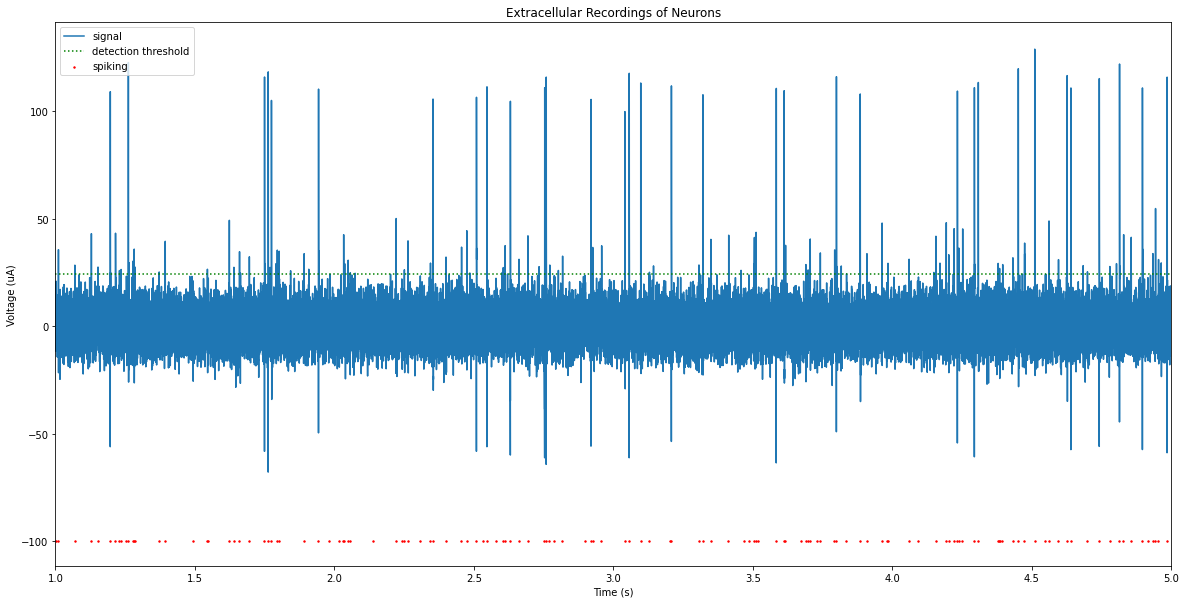

In [ ]:
# Visualize the signal
fs = 24000.0 # 24kHz sampling
plt.figure(figsize = (20,10))
seconds = np.arange(signal.shape[0])/fs
plt.plot(seconds, signal, label = 'signal')
plt.scatter(spiketimes/fs, np.ones(spiketimes.shape)*-100, c = 'r', s = 2, label = 'spiking')
plt.axhline(24, linestyle =':', c = 'g', label = 'detection threshold'); plt.legend(); 
plt.title('Extracellular Recordings of Neurons'); plt.xlim([1,5]); 
plt.xlabel('Time (s)'); plt.ylabel('Voltage (uA)')

### Preprocessing
As a preprocessing step, we want to perform filtering on the raw recorded signals. Then, we want to be able to extract spikes in order to classify the spikes. To prepare out features, we will perform peak detection to identify spiking in our recordings.

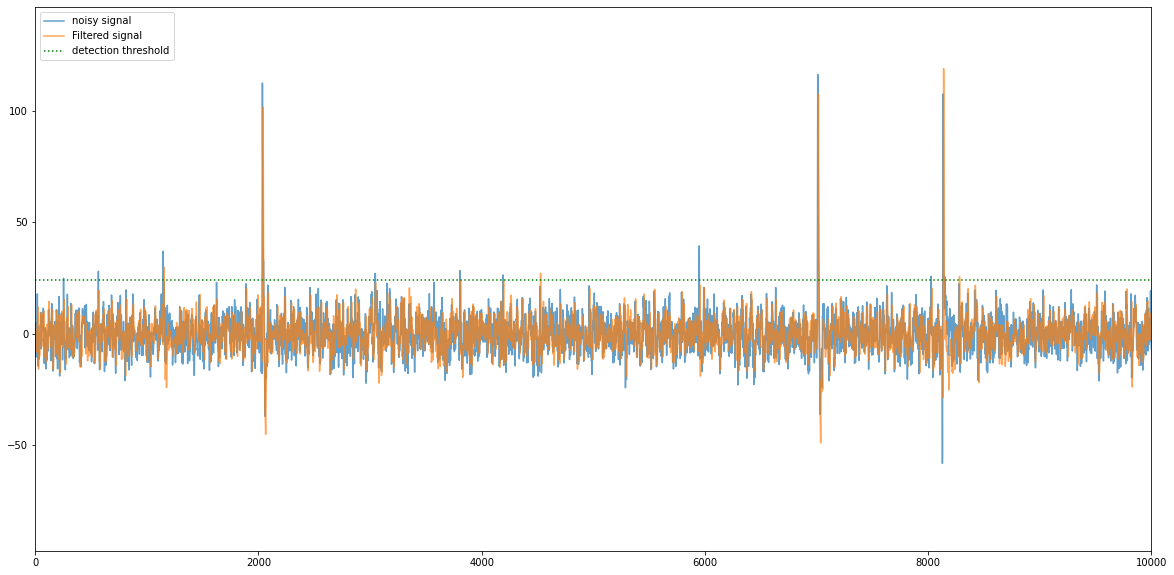

In [ ]:
# First, apply a bandpass filter to remove unnecessary frequencies in our raw recording.
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y
fs = 24000.0 # sampling frequency
lowcut = 30.0 # low frequency cutoff
highcut = 3000.0 # high frequency cutoff

plt.figure(figsize = (20,10))
plt.plot(signal, label = 'noisy signal', alpha = .7)
# filter the signal
signalfilt = butter_bandpass_filter(signal, lowcut, highcut, fs, order=6)
plt.plot(signalfilt, label='Filtered signal', alpha = .7)
plt.axhline(24, linestyle =':', c = 'g', label = 'detection threshold');
plt.axis('tight'); plt.legend(loc='upper left')
plt.xlim([0,10000]); plt.show()


Text(0.5, 1.0, 'Detected Peaks')

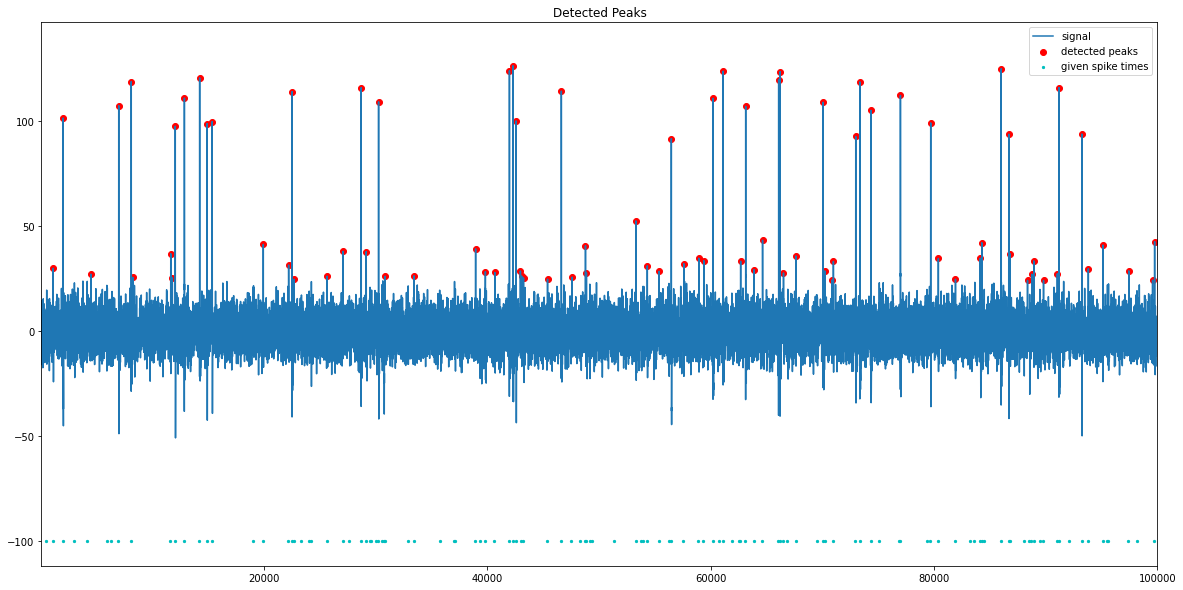

In [ ]:
# Next, we will perform peak detection. 
# There are various algorithms out there to detect peaks, but in our case, we will perform detection using scipy's algorithm.
from scipy.signal import find_peaks, peak_prominences
thres = 24

pks = find_peaks(signalfilt, height = thres, distance = 60)[0]
plt.figure(figsize = (20,10))
plt.plot(signalfilt, label = 'signal')
plt.scatter(pks, signalfilt[pks], c = 'r', label = 'detected peaks')
plt.scatter(spiketimes, np.ones(spiketimes.shape)*-100, c = 'c', s = 5, label = 'given spike times')
plt.xlim([100,100000]); plt.legend(); plt.title('Detected Peaks')

Text(0.5, 1.0, 'Spike Waveforms')

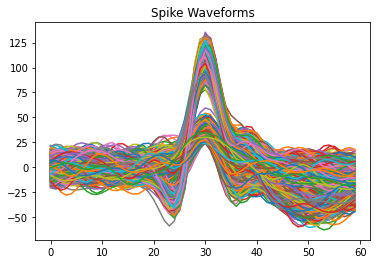

In [ ]:
# From our detected peaks, we then want to extract waveforms from detected peaks
# These will be the signals around the peaks that we detected. These signals will become our features in classification.
waveforms = list()
leftlim = 30
rightlim = 30
for p in pks:
  if p < leftlim:
    continue;
  if (len(signalfilt) - p) < rightlim: 
    continue;
  waveforms.append(signalfilt[p-leftlim:p+rightlim])

## plot the waveforms to visualize the data you will be working with
## CODE HERE
waveforms = np.vstack(waveforms)
plt.plot(np.vstack(waveforms).T); plt.title('Spike Waveforms')

# Spike Sorting: Training
Since this neural signal is simulated, we already have prior knowledge of assigned neural classes. In this example, we will use this knowledge to validate our classification method. In practice, you do not know these underlying classes and will have to performed un-supervised classification. 

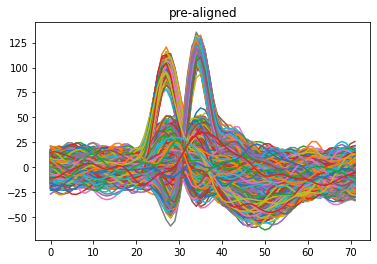

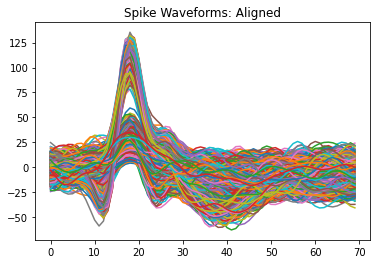

In [ ]:
waveforms = list()
leftlim = 20
rightlim = 50

plt.figure(); plt.title('pre-aligned');
for p in spiketimes:
  testwave = signalfilt[p-2:p+70]
  pk = find_peaks(testwave)[0]
  plt.plot(testwave)
  pk = pk[np.argmax(testwave[pk])]
  waveforms.append(signalfilt[p+pk-leftlim:p+pk+rightlim])
waveforms = np.vstack(waveforms)
plt.show();  plt.figure(); 
plt.plot(waveforms.T); 
plt.title('Spike Waveforms: Aligned');

Now we have extracted our aligned waveforms and put them in `waveforms_df`.

The classes are represented by the column `class`.

Below, plot out all the spikes within each class, as well as the average spike waveform.

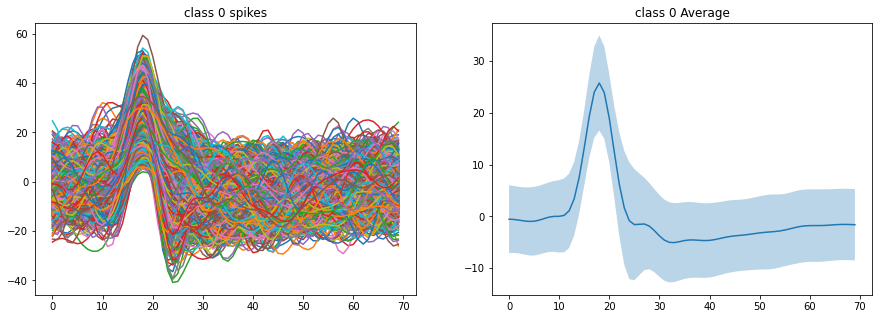

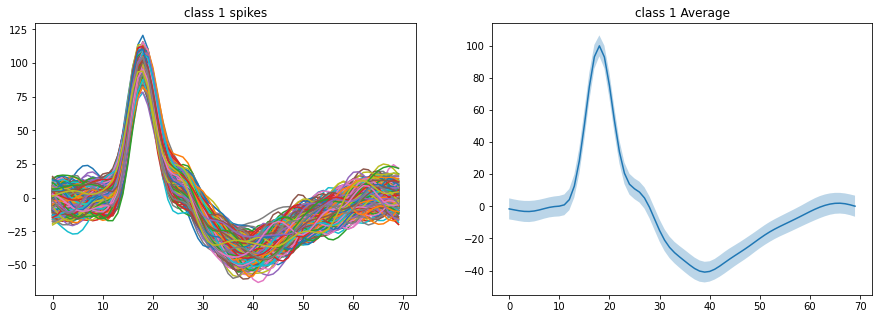

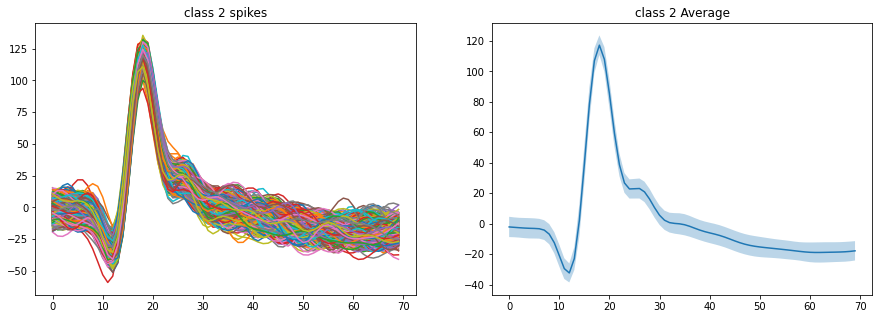

In [ ]:
# Now plot each of the classes.
# Spike classes are in spikeclass and there are 3 classes (2 corresponding to individual neurons, one class a mix of multiple neurons)
waveforms_df = pd.DataFrame(waveforms)
waveforms_df['class'] = spikeclass

## CODE HERE
for c, g in waveforms_df.groupby('class'):
  fig, ax = plt.subplots(1,2, figsize = (15,5));
  g = g.drop('class', axis=1).T

  ax[0].plot(g); 
  ax[0].set_title('class {} spikes'.format(c));
  ax[1].plot(g.mean(axis=1).values)
  std = g.std(axis=1).values
  ax[1].fill_between(list(g.index), g.mean(axis=1).values-std, g.mean(axis=1).values+std, alpha = .3)
  ax[1].set_title('class {} Average'.format(c));

## Dimensionality reduction and clustering.

First, let's split our data into training and test sets. You can use the train_test_split function from sklearn.

In [ ]:
# recall your training data waveforms are in waveforms, and your labels are in spikeclass
from sklearn.model_selection import train_test_split

## CODE HERE
X_train, X_test, y_train, y_test = train_test_split(waveforms, spikeclass, test_size=0.35, random_state=42, stratify = spikeclass)

## END CODE 

num_train, dims = X_train.shape
num_test, _ = X_test.shape
num_classes = 3

Now implement the function `project_data`. 

This function will take in `data`, and project it onto the basis given by `proj_basis`. `mean` is an optional parameter to be passed in in order to center our `data` in the original space before projection.

In [ ]:
## Implement the function project_data
## You want to return the output: proj_data

def project_data(data, proj_basis, mean = None, plot = False, labels = None, s = 5, c = None):
  """ Projects the data (adjusted by the mean) onto proj_basis into basis vectors 
    Inputs: data is of shape N x d
            proj_basis is of shape k x d
            mean is of shape d x 1 (optional)
            plot: true/false, whether the plot the projections. (optional)
            labels: pass in the label of each data to color when plotting.
            s, c: size and color, extra arguments to help with plotting. 
    Outputs: proj_data - the data projected onto proj_basis.
    """
  if mean is not None:
    data = data - mean

  ## CODE HERE
  # print(data.shape, proj_basis.shape, mean.shape)
  proj_data = data @ proj_basis.T

  ## END CODE
  if plot:
    if labels is not None:

      for i, l in enumerate(np.unique(labels)):
        if c is not None: plt.scatter(proj_data[labels == l,0], proj_data[labels == l ,1], label = "class: " + str(l), s = s, c = c)
        else: plt.scatter(proj_data[labels == l,0], proj_data[labels == l ,1], label = "class: " + str(l), s = s)
        plt.legend();
    else: 
      if c is None: plt.scatter(proj_data[:,0],proj_data[:,1], s = s)
      else:  plt.scatter(proj_data[:,0],proj_data[:,1], s = s, c = c)

  return proj_data

Now let us see an example of our waveforms projected onto two random coordinated.

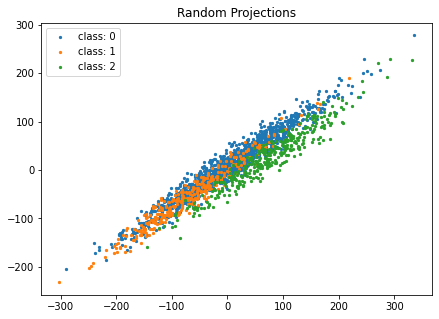

In [ ]:
# project onto 2 random coordinated
coord = np.random.rand(2, dims);
plt.figure(figsize = (7,5))
project_data(X_train, coord, mean = X_train.mean(axis=0), plot = True, labels = y_train);
plt.title('Random Projections');

In [ ]:
def train_PCA(data, n_components):
  """ This function will train your PCA projection by identifying a new basis for your data.
  Inputs: data is Nxd
          n_components is number of basis you want to reduce the dimensions to 
  Note: make sure you subtract the mean before you perform svd
  Outputs:
          basis: the basis identified by PCA
          mean: mean in the original space.
  """
  ### CODE HERE
  mean = data.mean(axis=0)
  U, S, Vt = np.linalg.svd(data-mean)
  basis = Vt[:n_components, :]

  ### CODE END
  return basis, mean

Now apply `train_PCA` to the waveform data and visualize your results.

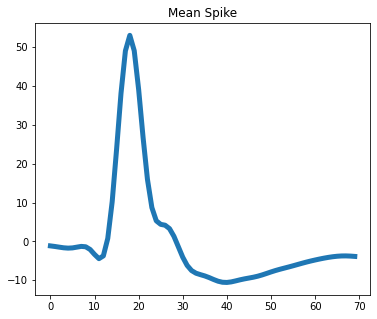

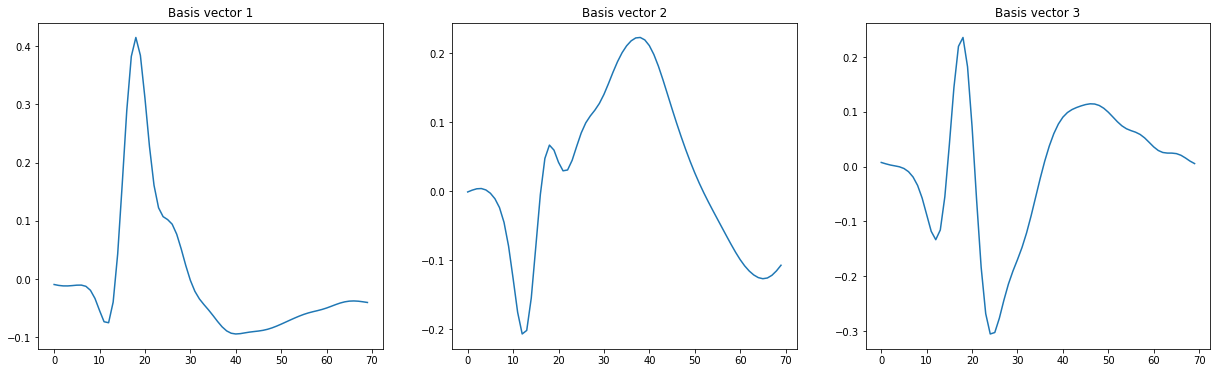

In [ ]:
## Train your PCA implementation on X_train, and obtain your basis vectors. Plot out at least 2 basis vectors.
# Put the mean spike signal in all_mean
n_bases = 3
## CODE HERE
n_bases = 3
all_basis, all_mean = train_PCA(X_train, n_bases)
## CODE END

plt.figure(figsize = (6,5))
plt.plot(all_mean, linewidth = 5); plt.title('Mean Spike'); plt.show();

## Plot the basis vectors
## CODE HERE
fix, ax = plt.subplots(1, len(all_basis), figsize = (len(all_basis)*7,6))
for i, basis in enumerate(all_basis):
  ax[i].plot(basis);
  ax[i].set_title('Basis vector ' + str(i+1))

Now that you have your PCA identified basis vectors, let us view the projections of the spike waveforms in that basis.

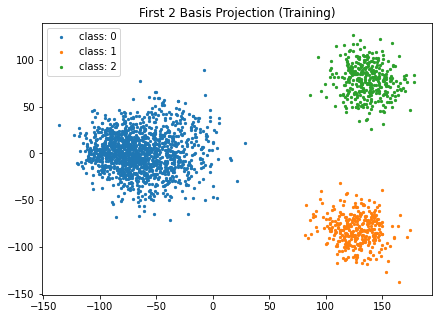

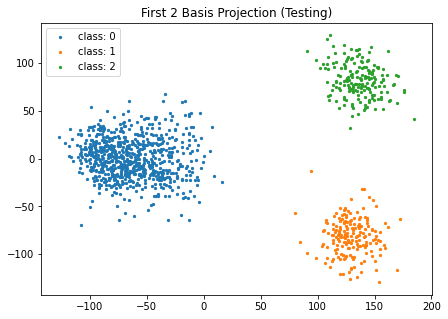

In [ ]:
plt.figure(figsize = (7,5))
proj_train = project_data(X_train, nbasis, mean = nmean, plot = True, labels = y_train);
plt.title('First 2 Basis Projection (Training)');

plt.figure(figsize = (7,5))
proj_test = project_data(X_test, nbasis, mean = nmean, plot = True, labels = y_test);
plt.title('First 2 Basis Projection (Testing)');

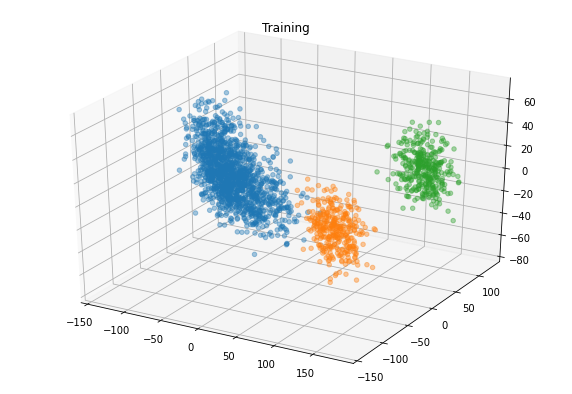

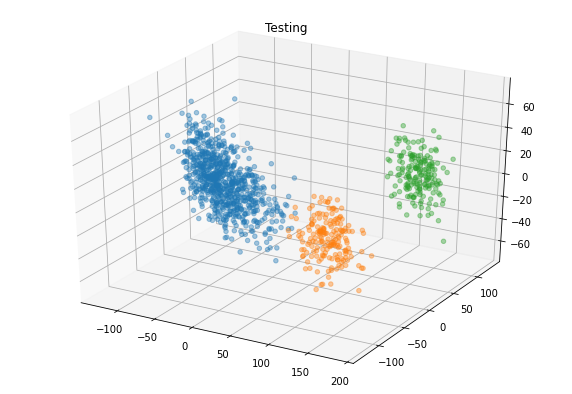

In [ ]:
# We can visualize the projection in 3 dimensions if your PCA returned more than 2 basis vectors.
from mpl_toolkits.mplot3d import Axes3D
if n_bases > 2:
  fig=plt.figure(figsize=(10,7))
  ax = fig.add_subplot(111, projection='3d')
  for i in np.arange(num_classes):
    Axes3D.scatter(ax, proj_train[y_train==i,0],proj_train[y_train==i,1],proj_train[y_train==i,2], alpha = .4)
  plt.title('Training')

  fig=plt.figure(figsize=(10,7))
  ax = fig.add_subplot(111, projection='3d')
  for i in np.arange(num_classes):
    Axes3D.scatter(ax, proj_test[y_test==i,0],proj_test[y_test==i,1],proj_test[y_test==i,2], alpha = .4)
  plt.title('Testing')



Now let us compare with sklearn PCA implementation.


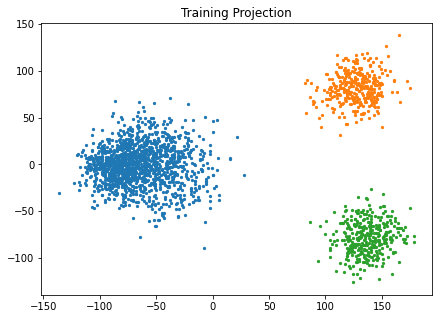

Text(0.5, 1.0, 'Test Projection')

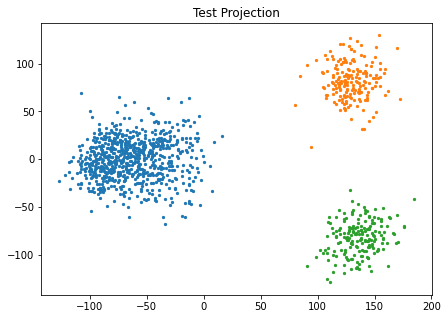

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_trans = pca.fit_transform(X_train)
plt.figure(figsize = (7,5))
for i in np.arange(num_classes):
  plt.scatter(X_trans[y_train==i,0], X_trans[y_train==i,1], s = 5)
plt.title('Training Projection')

plt.show();

X_trans = pca.transform(X_test)
plt.figure(figsize = (7,5))
for i in np.arange(num_classes):
  plt.scatter(X_trans[y_test==i,0], X_trans[y_test==i,1], s = 5)
plt.title('Test Projection')

# Spike Sorting: Clustering
When we do actual recordings, we do not know the underlying classes of the waveforms - so we will need to perform unsupervised clustering in order to determine the different groups of waveforms. We see that we have three distinct clusters in PCA. As such, we will implement an algorithm called k-means from sklearn which will perform unsupervised clustering in order to extract the cluster labels for you. The algorithm uses an iterative approach to identify centroids of k groups. You will learn more about this algorithm throughout the machine learning course.

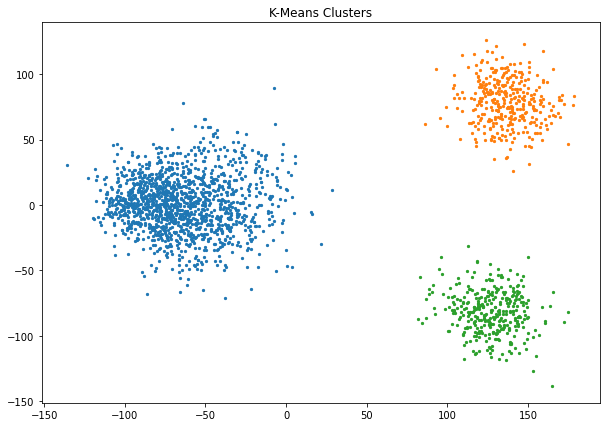

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42).fit(proj_train)
kmean_classes = kmeans.labels_

fig=plt.figure(figsize=(10,7))
for i in np.arange(num_classes):
  plt.scatter(proj_train[kmean_classes==i,0],proj_train[kmean_classes==i,1], s = 5)
plt.title('K-Means Clusters');

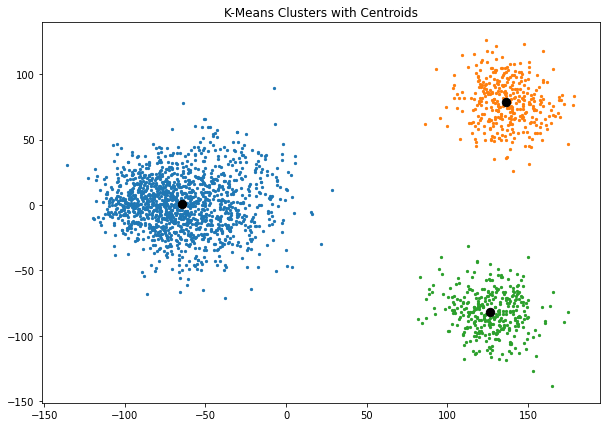

In [ ]:
## Now that we identified the 3 clusters, find the centroids.
## Hint: the centroids are the average of the points in each cluster.

centroid = list()
for i in np.arange(3):
## CODE HERE
  centroid.append(proj_train[kmean_classes == i,:].mean(axis=0))
## CODE END

fig=plt.figure(figsize=(10,7))
for i in np.arange(num_classes):
  plt.scatter(proj_train[kmean_classes==i,0],proj_train[kmean_classes==i,1], s = 5)
  plt.scatter(centroid[i][0], centroid[i][1], c = 'k', s = 70)
plt.title('K-Means Clusters with Centroids');

# Spike Sorting: Classifying New Signals

Now that you have projected and clustered your data, you want to be able to identify the class of new spike waveforms. 

Implement the function `classify_neuron`, where given a new waveform shape, classify the waveform based upon the closest centroid.

In [ ]:
# Implement the function classify_neuron. 
# You want to compute distances to each centroid for each waveform
# Then find the class of the closest centroid to classify your waveform.
def classify_neuron(proj_waveform, centroid):
  """Inputs: proj_waveform: Nxd matrix of projected neuronal spike waveforms
             centroid: centroids of your classes
     Outputs: classes (Nx1) for each waveform.
  """
  nclass = len(centroid)
  distances = np.empty((proj_waveform.shape[0], nclass))
  ## CODE HERE

  for i in np.arange(nclass):
    distances[:, i] = np.linalg.norm(proj_waveform - centroid[i], axis = 1)

  ## CODE END
  return np.argmin(distances, axis = 1)

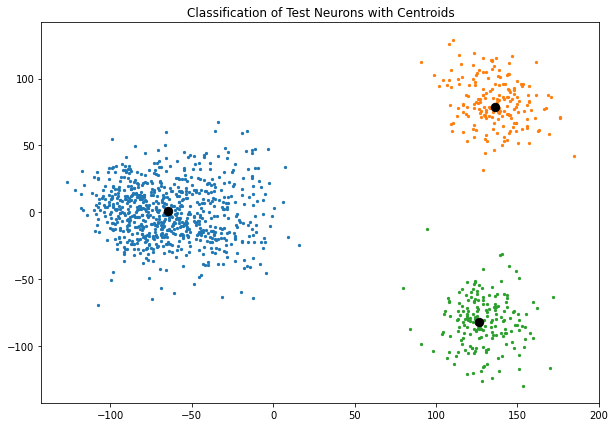

In [ ]:
proj_test = project_data(X_test, nbasis, nmean)
test_classes = classify_neuron(proj_test, centroid)

fig=plt.figure(figsize=(10,7))
for i in np.arange(num_classes):
  plt.scatter(proj_test[test_classes==i,0],proj_test[test_classes==i,1], s = 5)
  plt.scatter(centroid[i][0], centroid[i][1], c = 'k', s = 70)
plt.title('Classification of Test Neurons with Centroids');

# Beyond Spike Sorting

Congratulations! Now you have performed spike sorting, clustered neuronal signal, and performed classification on new signals. The next few blocks show you a few analytics you can extract from spike sorting.

You can count the number of times that each neuron fired in a time frame...

In [ ]:
# Count number of times single neurons fire in the full signal
proj_all = project_data(waveforms, nbasis, nmean)
classes_all = classify_neuron(proj_all, centroid)

num_firings = np.unique(classes_all, return_counts = True)[1]

print('Neuron 1 fired {} times'.format(num_firings[1]))
print('Neuron 2 fired {} times'.format(num_firings[2]))

Neuron 1 fired 529 times
Neuron 2 fired 529 times


You can look at interspike intervals - this tells you the frequency of a neuron's activity

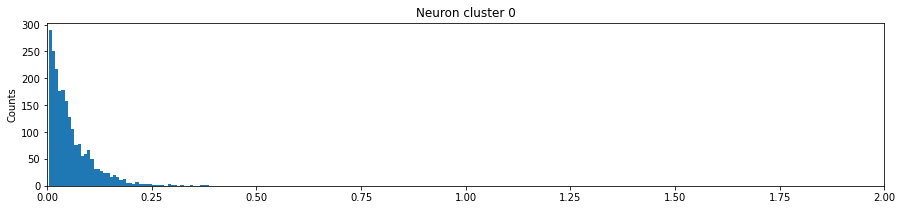

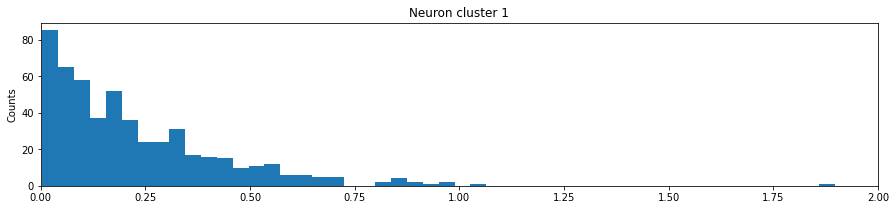

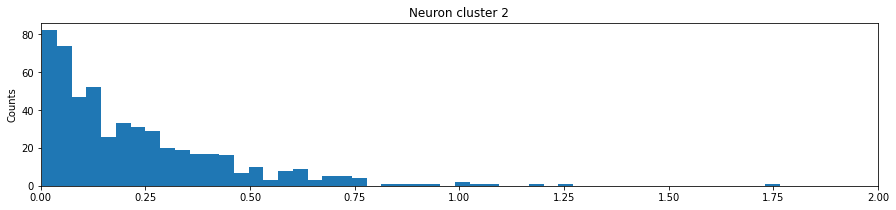

In [ ]:
# look at interspike intervals for each cluster!
for i in np.arange(num_classes):
  times = spiketimes[classes_all == i]
  time_diff = np.diff(times)/fs
  plt.figure(figsize = (15,3))
  plt.hist(time_diff, bins = 50); plt.ylabel('Inter-spike interval (seconds)')
  plt.xlim([0, 2]); plt.title('Neuron cluster '+ str(i)); plt.ylabel('Counts')
  plt.show()

You can also look at the spike trains - which are the spikes of each neuron over time, and examine its activity over time!. 

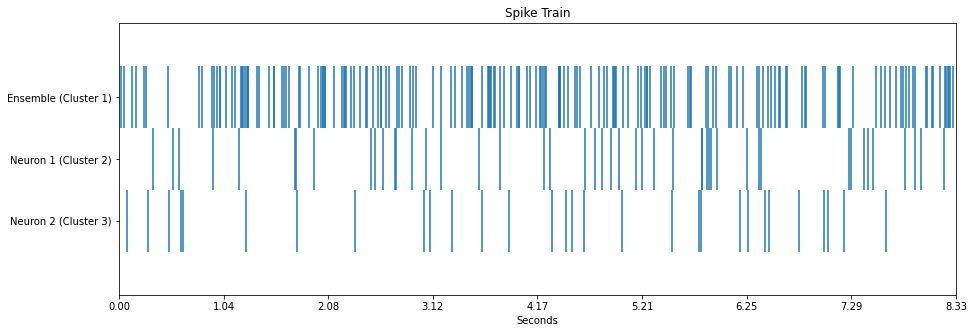

In [ ]:
plt.figure(figsize = (15,5))
for i in np.arange(3):
  plt.eventplot(spiketimes[classes_all == i], lineoffsets = -i);
plt.xlim([0,200000]); plt.yticks([0, -1, -2], ['Ensemble (Cluster 1)','Neuron 1 (Cluster 2)','Neuron 2 (Cluster 3)']);
plt.xticks(np.linspace(0, 200000, 9), ["{:.2f}".format(x) for x in np.linspace(0, 200000/fs, 9)]); plt.xlabel('Seconds');
plt.title('Spike Train');